一個模型服務多個風格(Multiple-Style-Per-Model:MSPM)
=============================
作者 : 湯沂達 https://github.com/mistake0316

-------------

簡介
------------
在上一個版本的程式碼我們復現了論文 `Perceptual Losses for Real-Time Style Transfer and Super-Resolution<https://arxiv.org/abs/1603.08155>`。
<img src="https://imgur.com/R11Jjho.jpg" width="800px"/><br>
上一版本的程式碼是找一張一個模型，使得任意圖片輸入的對應`固定風格`的損失函數最小，如上圖所示。<br>
<img src="https://i.imgur.com/5lR9PXo.png" width="800px"/><br>
而這次的記事本是要復現這個論文`A Learned Representation For Artistic Style<https://arxiv.org/abs/1610.07629>`<br>
要使得一個模型能夠服務<font size="6rem">多張</font>固定的風格影像，如上圖所示。<br>
核心精神是在每個激活函數前經過 Conditional Instance Normalization
```python
# x.shape : (b, c, w, h)
# 1.把輸出沿著`w, h`方向做標準化(減平均值，除以標準差)
norm_layer = torch.nn.InstanceNorm2d(c,affine=False)
x_norm = norm_layer(x)
# 2. 為n張風格影像在每層註冊一組可訓練的放大值(`gamma`)、位移(`beta`)
# gamma, beta have shape (n, c) 
# 調用第s張風格圖的放大值、位移
gamma_s = gamma[s].view(1, c, 1, 1)
beta_s = beta[s].view(1, c, 1, 1)
# 3. 取得輸出
z = gamma_s*x_norm + beta_s
```

<h2>與上一份程式碼不同處</h2>
單純的增加應付多張風格圖的gamma, beta參數，以及對應的運行函式

主要參考：
1. https://github.com/Aftaab99/pytorch-multiple-style-transfer

In [1]:
#@title 導入函式庫
!pip -q install torchinfo

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
import cv2

import torchvision.transforms as transforms
import torchvision.models as models
import torchvision

import torchinfo

from tqdm.auto import tqdm
from collections import OrderedDict
import numpy as np

import copy
import re
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device:{device}")

device:cuda


In [2]:
#@title 下載影像
!rm -rf Neural-Style-Transfer
!git clone https://github.com/titu1994/Neural-Style-Transfer
!mv ./Neural-Style-Transfer/images/inputs ./images
!rm -rf Neural-Style-Transfer

Cloning into 'Neural-Style-Transfer'...
remote: Enumerating objects: 1421, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 1421 (delta 8), reused 12 (delta 4), pack-reused 1393
Receiving objects: 100% (1421/1421), 68.19 MiB | 29.90 MiB/s, done.
Resolving deltas: 100% (827/827), done.


In [3]:
#@title 下載預訓練模型 & 對應影像
%%bash
wget -q https://github.com/Aftaab99/pytorch-multiple-style-transfer/blob/master/pytorch_models/style_model.pth?raw=true -O style_model.pth

folder=example_styles
mkdir -p $folder
for img_name in {bird,candy,canvas,cat,composition_vii,dr_gache,edtaonisl,empire,escher_sphere,eternal,family,feathers,flower_vase,frida_kahlo,graffiti,green_field,hawaii,la_muse,lampertz,matisse,maulbeerbaum,modern_art,mona_lisa,monet,moon,mosaic,mosaic2,mural,musical_man,newspaper,old_guitarist,passieo}
do
  wget -q https://raw.githubusercontent.com/Aftaab99/pytorch-multiple-style-transfer/master/images/style_images/${img_name}.jpg -O $folder/$img_name.jpg
done

In [4]:
#@title 不用看，但是要跑的程式碼區塊
# 由於我修改了點程式碼，所以讀取方式有些差異，這邊做一些條動
state_dict = torch.load("style_model.pth")
modified_state_dict = OrderedDict()
for key, weight in state_dict.items():
  if "embed" not in key:
    modified_state_dict[key] = weight
    continue
  # "embed" in key
  ith_cin = key[2]
  num_of_channels = weight.shape[1]//2
  modified_state_dict[
      f"cin{ith_cin}.gamma"
  ] = weight[:, :num_of_channels]
  modified_state_dict[
      f"cin{ith_cin}.beta"
  ] = weight[:, num_of_channels:]

torch.save(
    modified_state_dict,
    "modified_style_model.pth"
)


In [5]:
content_paths = os.listdir("images/content")
content_paths

['ancient_city.jpg',
 'sagano_bamboo_forest.jpg',
 'golden_gate.jpg',
 'Aurea-Luna.jpg',
 'Dawn Sky.jpg',
 'tubingen.jpg',
 'Sunlit Mountains.jpg',
 'winter-wolf.jpg',
 'Dipping-Sun.jpg',
 'Japanese-cherry-widescreen-wallpaper-Picture-1366x768.jpg',
 'Kinkaku-ji.jpg',
 'blue-moon-lake.jpg']

In [6]:
#@title available styles
style_names = os.listdir("example_styles")
print(("idx", "style"))
print(
  *[(idx, name) for idx, name in enumerate(style_names)],
  sep="\n"
)

('idx', 'style')
(0, 'mural.jpg')
(1, 'passieo.jpg')
(2, 'eternal.jpg')
(3, 'mona_lisa.jpg')
(4, 'hawaii.jpg')
(5, 'newspaper.jpg')
(6, 'monet.jpg')
(7, 'candy.jpg')
(8, 'lampertz.jpg')
(9, 'moon.jpg')
(10, 'modern_art.jpg')
(11, 'composition_vii.jpg')
(12, 'matisse.jpg')
(13, 'mosaic2.jpg')
(14, 'frida_kahlo.jpg')
(15, 'old_guitarist.jpg')
(16, 'empire.jpg')
(17, 'graffiti.jpg')
(18, 'escher_sphere.jpg')
(19, 'feathers.jpg')
(20, 'cat.jpg')
(21, 'bird.jpg')
(22, 'flower_vase.jpg')
(23, 'maulbeerbaum.jpg')
(24, 'la_muse.jpg')
(25, 'mosaic.jpg')
(26, 'family.jpg')
(27, 'dr_gache.jpg')
(28, 'canvas.jpg')
(29, 'edtaonisl.jpg')
(30, 'green_field.jpg')
(31, 'musical_man.jpg')


In [7]:
# desired size of the output image
imsize = 512 #@param {type:"number"}

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])


def image_loader(image_name, mod=64):
    image = Image.open(image_name)
    image = loader(image)
    image = image[:,:image.shape[1]//mod*mod, :image.shape[2]//mod*mod].unsqueeze(0)
    return image.to(device, torch.float)

content_path = "./images/content/Kinkaku-ji.jpg" #@param {type:"string"}
content_img = image_loader(content_path)

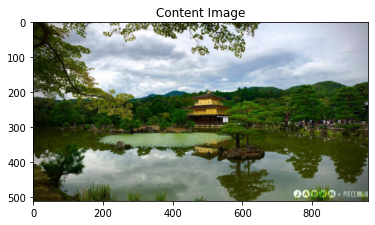

In [12]:
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    fig = plt.imshow(image)
    plt.title(title)
    plt.show()
    
imshow(content_img, title='Content Image')

In [13]:
#@title Style Images
style_images = [image_loader(f"./example_styles/{name}") for name in style_names]

for ith_img in range(len(style_images)):
  imshow(
      style_images[ith_img],
      title=f"{style_names[ith_img]}",
  )

Output hidden; open in https://colab.research.google.com to view.

## 風格轉換模型
修改自 : https://github.com/Aftaab99/pytorch-multiple-style-transfer/blob/master/transformer_net.py <br>

只需要看
1. `ConditionalInstanceNorm2d`
2. `TransformerNet` 內的 `__init__`, `cin`

這邊我修改了<br>
`ConditionalInstanceNorm2d`<br>
的部分程式碼，以及新增了風格內差的執行功能

# ConditionalInstanceNorm2d

In [14]:
class ConditionalInstanceNorm2d(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(ConditionalInstanceNorm2d, self).__init__()
        self.num_features = num_features
        self.inst_norm = torch.nn.InstanceNorm2d(num_features, affine=False)
        self.gamma = torch.nn.Parameter(
          1+0.02*torch.randn(num_classes, num_features)
        )
        self.beta = torch.nn.Parameter(
          torch.zeros(num_classes, num_features)
        )
        # 這邊有一個心酸血淚史
        # 原本嘗試自己手刻並訓練
        # 原本gamma跟beta的初始值是random normal(mean=0,std=1)
        # 結果怎樣都訓練不起來
        # 後來去找到了別人的初始參數設置，才能訓練得起來
        
        # 溫馨提示：下方懶得看可以跳過
        # 別人的初始設定值如下：
        # 初始放大值是 1 + 微小擾動
        # 初始位移值是 0
        # 想想也合理
        # 每個風格大致不對輸出做大調動的情況下出發
        # 並慢慢調整參數
        # 若用我原本的初始值，可能會特別偏袒或歧視某些輸出

    def forward(self, x, style_idx_scale_dict):
        if isinstance(style_idx_scale_dict, int):
          style_idx_scale_dict = {
              style_idx_scale_dict : 1.0
          }
        elif isinstance(style_idx_scale_dict, dict):
          pass
        else:
          raise
        
        out = self.inst_norm(x)
        def _get(weight_tensor):
          scale_sum = sum(style_idx_scale_dict.values())
          idx_weight_dict = {
              idx : weight_tensor[idx]*scale/scale_sum
              for idx, scale in style_idx_scale_dict.items()
          }
          return sum(idx_weight_dict.values())
          
        gamma = _get(self.gamma).view(1,-1,1,1)
        beta = _get(self.beta).view(1,-1,1,1)
        return gamma*out+beta

### Whole model

In [15]:
class TransformerNet(torch.nn.Module):
    def __init__(self, style_num):
        super(TransformerNet, self).__init__()
        self.conv1 = ConvLayer(3, 32, kernel_size = 9, stride = 1) 
        self.cin1 = ConditionalInstanceNorm2d(32, style_num)

        self.conv2 = ConvLayer(32, 64, kernel_size = 3, stride = 2)
        self.cin2 = ConditionalInstanceNorm2d(64, style_num)

        self.conv3 = ConvLayer(64, 128, kernel_size = 3, stride = 2)
        self.cin3 = ConditionalInstanceNorm2d(128, style_num)

        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)

        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size = 3, stride = 1, upsample = 2)
        self.cin4 = ConditionalInstanceNorm2d(64, style_num)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size = 3, stride = 1, upsample = 2)
        self.cin5 = ConditionalInstanceNorm2d(32, style_num)
        self.deconv3 = ConvLayer(32, 3, kernel_size = 9, stride = 1)
        self.relu = torch.nn.ReLU()

    def forward(self, model_in):
        X,style_id=model_in
        y = self.relu(self.cin1(self.conv1(X), style_id))
        y = self.relu(self.cin2(self.conv2(y), style_id))
        y = self.relu(self.cin3(self.conv3(y), style_id))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.cin4(self.deconv1(y), style_id))
        y = self.relu(self.cin5(self.deconv2(y), style_id))
        y = self.deconv3(y)         
        return y


### ConvLayer

In [16]:
class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

### ResidualBlock

In [17]:
class ResidualBlock(torch.nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out

### UpsampleConvLayer

In [18]:
class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

### Preprocess



In [19]:
def preprocess(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406],device=tensor.device).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225],device=tensor.device).view(-1, 1, 1)
    # tensor = tensor/255.0
    return (tensor-mean)/std

## 開始執行吧！

In [20]:
style_model = TransformerNet(style_num=32)
style_model.load_state_dict(
    torch.load("modified_style_model.pth")
)
style_model.to(device)
style_model.eval()
print("model loaded")

model loaded


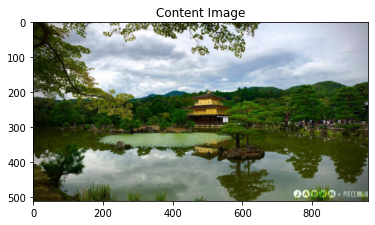

In [21]:
imshow(content_img, title='Content Image')

In [22]:
with torch.no_grad():
  for ith_style in tqdm(range(32)):
    out = style_model(
        (preprocess(content_img), ith_style)
    )
    out = out.clamp(0,255)
    out = out/255
    imshow(out, title=f"{ith_style}-th style_idx")

Output hidden; open in https://colab.research.google.com to view.

# 風格內差

In [23]:
style_1_idx = 16
style_2_idx = 12
n_frames = 300
style_scale_dict_list = [
    {style_1_idx:w, style_2_idx:1-w}
    for w in np.linspace(1,0,n_frames)
]
outs_list = []
with torch.no_grad():
  for ith_scale_setting in tqdm(style_scale_dict_list):
    outs_list.append(
      style_model(
        (preprocess(content_img), ith_scale_setting)
      ).clamp(0,255)
    )

  0%|          | 0/300 [00:00<?, ?it/s]

In [24]:
#影片生成
output_path = f"out_{style_1_idx}_{style_2_idx}.mp4"
out_video_writer = cv2.VideoWriter(
    output_path,
    cv2.VideoWriter_fourcc(*"mp4v"),
    30,
    (outs_list[0].shape[-1], outs_list[0].shape[-2])
)
for torch_tensor in tqdm(outs_list):
  out = torch_tensor.cpu().numpy()
  out = out.astype(np.uint8)
  out = np.einsum("bchw->bhwc",out)[0,...,::-1] # remove batch, rgb->bgr
  out_video_writer.write(out)
out_video_writer.release() 

  0%|          | 0/300 [00:00<?, ?it/s]

### 可以下載並觀看影片(out_X_X.mp4)

In [25]:
#@title 預先跑好的內差結果
from IPython.display import HTML
from_to_list = ['16_9', '16_12', '16_22', '16_29', '16_30']
urls= ['https://i.imgur.com/nAW3Qn2.mp4', 'https://i.imgur.com/Pf0zHVe.mp4', 'https://i.imgur.com/6jnPra2.mp4', 'https://i.imgur.com/gTlPwiH.mp4', 'https://i.imgur.com/4vj72wv.mp4']

string_list = [
    "<h1>我預先把一些影片上傳到imgur上了</h1>",
    '<div style="display:flex;flex-wrap: wrap;align-items: center;justify-content: space-around;">',
    *[
        '<div style="width: 45%">'
        f"<p style='text-align: center;'>{from_to} : <a href={url}>{url}</a></p>"
        f"<video src='{url}' controls autoplay width=100% loop/>"
        "</div>"
        for from_to, url in zip(from_to_list, urls)
    ],
    "</div>"
]
HTML("".join(string_list))

# 練習
1. 嘗試把nn.InstanceNorm2d替換成手刻的方法
2. 回想一下演算法演進過程
3. 數參數：一個風格化的參數相對於卷基層的參數，比例是多少？